In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Import the usual suspects. Any new functions will be introduced individually for clarity.
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# Balance Classes

In [3]:
# First we will balance our classes

# read in dataset
df = pd.read_pickle('data/combined_data_cleaned_corrected.pkl')

0    0.813057
1    0.186943
Name: shootings_abv_avg, dtype: float64


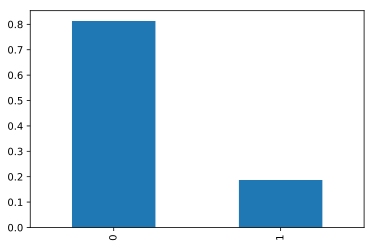

In [4]:
# demonstrate class imbalance
target_pcts = df.shootings_abv_avg.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

In [5]:
# here is the imbalance in y
Counter(df.shootings_abv_avg)

Counter({0: 2553, 1: 587})

2553 counties have not had police shootings in the past 3 years, and 587 have

In [6]:
## Add some features:

# Minority term:
df['Minority'] = df['Black'] + df['Hispanic'] + df['Native'] + df['Pacific']

# Minority-Drive interaction term
df['Mnr_Drive'] = df['Minority'] * df['Drive']

# Minority-Unemployment interaction term
df['Mnr_Unempl'] = df['Minority'] * df['Unemployment']

# Minority-Voting Age interaction term
df['Mnr_Vtg'] = df['Minority'] * df['VotingAgeCitizen']

# Minority-Poverty interaction term
df['Mnr_Pov'] = df['Minority'] * df['Poverty']

# Split data into train, validation, and test sets

In [ ]:
X = df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1)
y = df.shootings_abv_avg

In [ ]:
X.columns

In [7]:
# Drop more columns!
X = df.drop(labels = ['shootings_abv_avg', 'County', 'Professional', 'Service', 
                      'Office', 'Construction', 'Production', 'Carpool', 
                      'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'Employed', 
                      'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
                      'Minority'], axis = 1)
y = df.shootings_abv_avg

In [8]:
## Split the data 80 - 20 train_val/test sets, stratifying on the target variable

X_tr_val, X_te, y_tr_val, y_te = train_test_split(X, y, test_size=0.20, random_state=42, 
                                                  stratify = y)

## Split the train_val into train/val sets, stratifying on the target variable 

X_tr, X_val, y_tr, y_val = train_test_split(X_tr_val, y_tr_val, test_size=0.25, random_state=42, 
                                            stratify = y_tr_val)

# Baseline Model

In [9]:
from sklearn import linear_model, svm, metrics

logreg_model = linear_model.LogisticRegression(solver="sag")

In [10]:
logreg_model.fit(X_tr, y_tr)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
y_pred = logreg_model.predict(X_val)

print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       511
           1       0.00      0.00      0.00       117

   micro avg       0.81      0.81      0.81       628
   macro avg       0.41      0.50      0.45       628
weighted avg       0.66      0.81      0.73       628



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# With Class Weights

In [13]:
logreg_weights = linear_model.LogisticRegression(class_weight="balanced", solver="sag")

logreg_weights.fit(X_tr, y_tr)

y_pred = logreg_weights.predict(X_val)

print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       511
           1       0.23      0.50      0.32       117

   micro avg       0.60      0.60      0.60       628
   macro avg       0.54      0.56      0.52       628
weighted avg       0.73      0.60      0.64       628



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Standardize and Fit

In [14]:
type(y_tr)

pandas.core.series.Series

In [15]:
## Fit the scaler to the train set
std = StandardScaler()
std.fit(X_tr)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
pickle.dump(std, open('scaler.pkl', 'wb'))  

In [17]:
## Scale the Predictors on the train, val, and test set
X_tr = std.transform(X_tr)
X_val = std.transform(X_val)
X_te = std.transform(X_te)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [19]:
cols = X.columns.values
X_tr = pd.DataFrame(X_tr, columns = cols)
X_val = pd.DataFrame(X_val, columns = cols)
X_te = pd.DataFrame(X_te, columns = cols)

# Save train, val, and test sets for later

In [ ]:
# Save them!
type(X_te_a)

In [ ]:
X_tr_a.columns.values

In [20]:
X_tr.to_pickle('data/X_tr_f1.pkl')
X_val.to_pickle('data/X_val_f1.pkl')
X_te.to_pickle('data/X_te_f1.pkl')

y_tr.to_pickle('data/y_tr_f1.pkl')
y_val.to_pickle('data/y_val_f1.pkl')
y_te.to_pickle('data/y_te_f1.pkl')

# EDA to put me at ease

In [ ]:
df_resampled = X_tr_s

In [ ]:
df_resampled.columns

In [ ]:
df_resampled['shootings_abv_avg'] = y_resampled_sm

In [ ]:
df_resampled.sample(10)

## Make pairplots with hues of important features

In [ ]:
df_resampled.columns

In [ ]:
subset_df = df_resampled[['Office', 'SelfEmployed', 'percent_men', 
                          'Asian', 'Hispanic', 'White', 'MeanCommute',
                         'PrivateWork', 'Walk', 'Poverty', 'shootings_abv_avg']].copy()

In [ ]:
subsub = subset_df[['Office', 'SelfEmployed', 'shootings_abv_avg']]
cols = list(subsub.columns)
for i, col1 in enumerate(cols):
    if i < len(cols)-1:
        for j, col2 in enumerate(cols):
            if j > i:
                g = sns.scatterplot(col1, col2, hue='shootings_abv_avg', data = subsub, palette='husl')
                g.show()

In [ ]:
sns.scatterplot('Office', 'SelfEmployed', hue = 'shootings_abv_avg', data=subset_df, palette='husl')

In [ ]:
sns.scatterplot('Office', 'shootings_abv_avg', data=subset_df, palette='husl')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(subset_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [ ]:
df.corr()

In [ ]:
df.columns

In [ ]:
a = dict(df.iloc[1,:].drop(labels = ['shootings_abv_avg', 'County']))
a

In [ ]:
b = pd.DataFrame(a, index=[0])

In [ ]:
b_transformed = std.transform(b)

In [ ]:
df.sample(40).MeanCommute

In [ ]:
sns.pairplot(X)